In [15]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Activation, Concatenate
from keras import Sequential

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import SGD,Adam
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

#Different Transfer learning rate/models
#https://keras.io/api/applications/
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [16]:
train_dir = "grayscale"

train_df = pd.read_csv('file_types.csv')
train_df['ImageName'] = train_df['ImageName'].astype(str)
train_df['ImageName'] = train_df['ImageName'].astype(str).str.zfill(6)
train_df['Class'] = pd.factorize(train_df['FileType'])[0] 
train_df.head()

,ImageName,FileType,Class
0,000008,ppt,0
1,000027,csv,1
2,000039,xml,2
3,000067,xml,2
4,000081,txt,3


In [17]:
width = 100
height = 100

In [18]:
model = Sequential()

model.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (height, width, 1)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(GlobalAveragePooling2D())
model.add(Dense(300, activation="relu", name='rl'))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax', name='sm'))

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
X_tr = []
Y_tr = []
imges = train_df['ImageName'].values
for img_id in imges:
    file = os.path.join(train_dir, img_id) + '.png'
   
    temp = cv2.imread(file) 
            
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    temp = np.expand_dims(temp, axis=2)
    X_tr.append(temp)    
    Y_tr.append(train_df[train_df['ImageName'] == img_id]['Class'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, Y_tr, random_state = 0, shuffle=True) #use Y or dummy_y
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11847, 100, 100, 1)
(11847,)
(3950, 100, 100, 1)
(3950,)


In [22]:
batch_size = 32
nb_epoch = 100

In [23]:
%%time
# Train model
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.2,
              shuffle=True,
              verbose=2)

Epoch 1/100
297/297 - 42s - loss: 2.5698 - accuracy: 0.2245 - val_loss: 2.5958 - val_accuracy: 0.2401 - 42s/epoch - 142ms/step
Epoch 2/100
297/297 - 42s - loss: 2.3846 - accuracy: 0.2652 - val_loss: 2.3444 - val_accuracy: 0.2401 - 42s/epoch - 141ms/step
Epoch 3/100
297/297 - 42s - loss: 2.2015 - accuracy: 0.2778 - val_loss: 2.1026 - val_accuracy: 0.4768 - 42s/epoch - 141ms/step
Epoch 4/100
297/297 - 41s - loss: 2.0981 - accuracy: 0.2965 - val_loss: 2.0311 - val_accuracy: 0.2743 - 41s/epoch - 138ms/step
Epoch 5/100
297/297 - 42s - loss: 2.0617 - accuracy: 0.3048 - val_loss: 1.9941 - val_accuracy: 0.3055 - 42s/epoch - 141ms/step
Epoch 6/100
297/297 - 41s - loss: 2.0334 - accuracy: 0.3144 - val_loss: 1.9652 - val_accuracy: 0.3473 - 41s/epoch - 138ms/step
Epoch 7/100
297/297 - 42s - loss: 2.0059 - accuracy: 0.3311 - val_loss: 1.9378 - val_accuracy: 0.4688 - 42s/epoch - 142ms/step
Epoch 8/100
297/297 - 42s - loss: 1.9771 - accuracy: 0.3500 - val_loss: 1.9111 - val_accuracy: 0.4793 - 42s/epo

<AxesSubplot:>

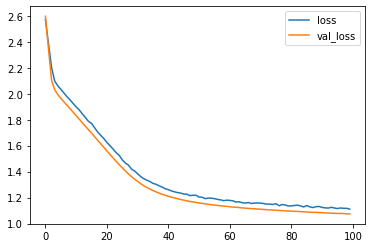

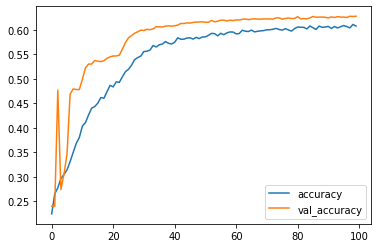

In [24]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [25]:
y_pred = model.predict(X_test)

In [26]:
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
cm

array([[ 88,   0,   0,   0,   0,   0,   0,   0,   0,   0,  98,   8,   0,
         43],
       [  0,   0,   0,  41,   0,   0,   0,   0,   0,   0,   0,   0,   7,
          0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,  42,
          0],
       [  0,   0,   0, 356,   0,   0,   0,   0,   0,   0,   0,   0, 466,
          0],
       [  0,   0,   0,  31,   0,   0,   0,   0,   0,   0,   0,   0,  24,
          0],
       [  1,   0,   0,   2,   0,   0,   0,   0,   0,   0, 101,   1,   0,
          0],
       [  9,   0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24,   0,   0,
          0],
       [  0,   0,   0,  21,   0,   0,   0,   0,   0,   0,   0,   0,  13,
          0],
       [  3,   0,   0,   0,   0,   0,   0,   0,   0,   0, 239,   0,   0,
          1],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,   0, 899,   0,  27,
          0],
       [  1,   0,   0,   0,   0,   0,   0, 

In [27]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.37      0.48       237
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        46
           3       0.67      0.43      0.52       822
           4       0.00      0.00      0.00        55
           5       0.00      0.00      0.00       105
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00       243
          10       0.64      0.97      0.77       930
          11       0.59      0.32      0.41       158
          12       0.60      0.92      0.73       962
          13       0.54      0.67      0.60       263

    accuracy                           0.62      3950
   macro avg       0.27      0.26      0.25      3950
weighted avg       0.54      0.62      0.55      3950



C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

<AxesSubplot:>

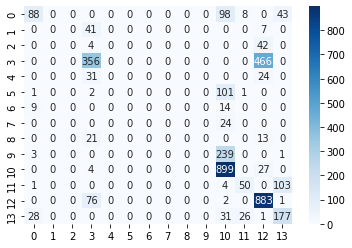

In [28]:
import seaborn as sns
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')